In [1]:
import time 
import os 
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import json
import ctypes


import pypore3d 
from pypore3d import *
from pypore3d.p3dFiltPy import *
from pypore3d.p3dBlobPy import *
from pypore3d.p3dSkelPy import *
from pypore3d.p3dSITKPy import *

from poreUtils import *

In [2]:
data_dir = 'D:\\sagar\\Data\\MD_1264_A1_1_Z3.3mm\\selected_roi\\'
raw_file = os.path.join(data_dir, '600-900x800-1100x1600-1900_8bit.raw')


Success. 



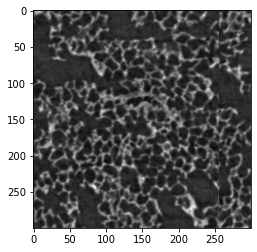

In [3]:
# File specifications
x, y, z = 300, 300, 300
res = 0.002 # 2 micron
# reading the 8bit raw file 

volc = py_p3dReadRaw8(raw_file, x, y, z)

vol = swigObjt2uint8Array(volc, x, y, z, plot=True)

Success. 

Success. 



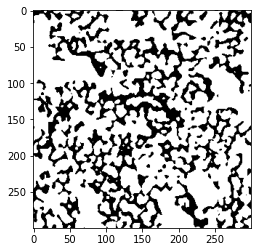

In [4]:
# Applying a median filter and thresholding for a binary image 
filt_volc = py_p3dMedianFilter8(volc, x, y, z, width=3)
th_volc, _  = py_p3dAutoThresholding8(filt_volc, x, y, z, methodNum=2) # method 2 is Otsu
invert_vol(th_volc, x,y,z)
th_vol = swigObjt2uint8Array(th_volc, x, y, z, plot=True)

## Basic Analysis w/o Clear Border filter 

In [7]:
# Result will be saved here
result = {}

# Using thresolded volume for Basic analysis
basic_stats = py_p3dBasicAnalysis(th_volc, x, y, z, resolution=res)
basic_analysis = formatBasicStats(basic_stats, definition=True)

result['basic_analysis_th_vol'] = basic_analysis

Success. 



In [9]:
thE_volc = py_p3d_Erode(th_volc, x, y, z, kWidth=1)
#thD_volc = py_p3d_Dilate(thE_volc, x, y, z, kWidth=1)

thE_vol = swigObjt2uint8Array(thE_volc, x, y, z)
#thD_vol = swigObjt2uint8Array(thD_volc, x, y, z)

Success. 

[b'ObjectType = Image\n', b'NDims = 3\n', b'DimSize = 300 300 300\n', b'ElementSpacing = 1 1 1\n', b'Offset = 0 0 0\n', b'TransformMatrix = 1 0 0 0 1 0 0 0 1\n', b'ElementType = MET_UCHAR\n', b'BinaryData = True\n', b'BinaryDataByteOrderMSB = False\n', b'ElementDataFile = D:\\sagar\\poreAnalysis\\tempOutMeta.raw\n']
Success. 



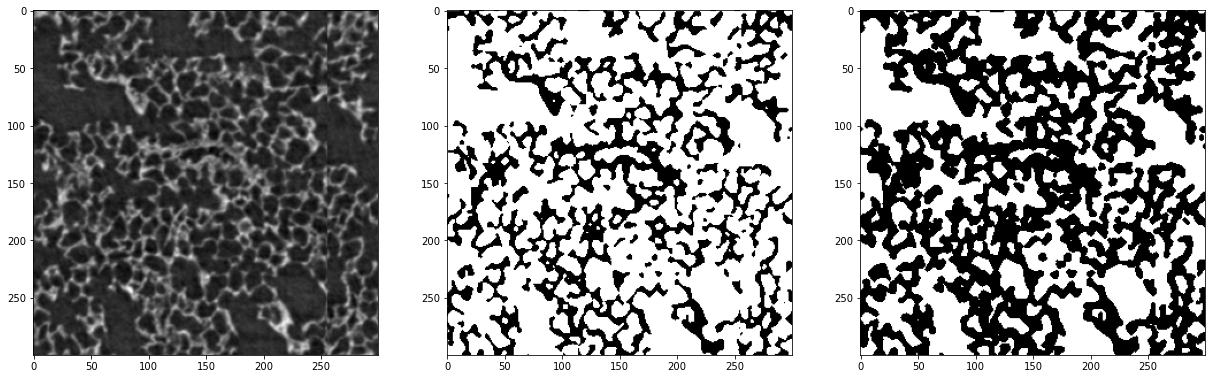

In [10]:
fig, axs = plt.subplots(1,3, figsize=(21,16))
axs[0].imshow(vol[150, :, :], cmap='gray')
axs[1].imshow(th_vol[150, :, :], cmap='gray')
axs[2].imshow(thE_vol[150, :, :], cmap='gray')
#axs[3].imshow(thD_vol[150, :, :], cmap='gray')
plt.show()

In [12]:
tifffile.imsave('poreAnalysisClearBoundary/600-900x800-1100x1600-1900_thVol_8bit.raw', th_vol)
tifffile.imsave('poreAnalysisClearBoundary/600-900x800-1100x1600-1900_thEVol_8bit.raw', thE_vol)


In [17]:
# Using thresolded Erode volume for Basic analysis
basic_stats = py_p3dBasicAnalysis(thE_volc, x, y, z, resolution=res)
basic_analysis = formatBasicStats(basic_stats)

result['basic_analysis_thE_vol'] = basic_analysis

Success. 



In [20]:
# Anisotropy Analysis
anisotropy_stats = py_p3dAnisotropyAnalysis(th_volc, x, y, z, resolution=res)
anisotropy_analysis = formatAnisotropyStats(anisotropy_stats, definition=True)
result['anisotropy_analysis_th_vol'] = anisotropy_analysis

anisotropy_stats = py_p3dAnisotropyAnalysis(thE_volc, x, y, z, resolution=res)
anisotropy_analysis = formatAnisotropyStats(anisotropy_stats)
result['anisotropy_analysis_thE_vol'] = anisotropy_analysis

Success. 

Success. 



In [21]:
result

{'basic_analysis_th_vol': {'definition': {'VV': 'Density (VV). A measure of density based on the number of object voxels with respect to the total number of volume  voxels.',
   'SV': 'Specific surface area (SV) [mm-1]. A measure of the surface of the object with respect to the total volume. Tipically it is related to the mechanical properties of the object.',
   'MV': 'Integral of mean curvature (MV)[mm-2]. A positive value implies the dominance of convex structures, while MV < 0 occurs  in the case of predominance of concave structures.',
   'CV': 'Euler characteristic (CV)[mm-3]. This is an index of connectivity of the object network.'},
  'result': {'VV': 0.715743641843097,
   'SV': -83564.3425236091,
   'MV': 0.715743641843097,
   'CV': -83564.3425236091}},
 'basic_analysis_thE_vol': {'result': {'VV': 0.5050764285929927,
   'SV': -53033.19577841358,
   'MV': 0.5050764285929927,
   'CV': -53033.19577841358}},
 'anisotropy_analysis_th_vol': {'definition': {'I': 'Isotropy index. It m

In [24]:
# Blob Analysis 
blob_analysis = {}
def_blob = { 'COUNT': 'The number of identified blobs.',
 'VOLUME': '[mm3] An array of length COUNT with the volume of each identified blob computed as the number of voxels rescaled  according to the specified voxel size.', 
 'MAX_SPHERE': '[mm] An array of length COUNT with the diameter of the maximum inscribed sphere of each identified blob. It is  computed as two times the maximum value of the Euclidean distance transform within the blob.', 
 'EQ_SPHERE': '[mm] An array of length COUNT with the diameter of the equivalent sphere, i.e. the diameter of a sphere with the  same volume as the blob. It is computed exploiting the inverse formula of the volume of a sphere.', 
 'MIN_AXIS': '[mm] An array of length COUNT with the minor axis length, i.e. the length of the shortest segment among all the  segments fully included into the blob and passing through its center of mass. The so-called “star” of segments from which  selecting the shortest is generated using random orientations. The "star" image can be optionally returned as output in order  to determine if more random segments have to be computed.', 
 'MAX_AXIS': '[mm] An array of length COUNT with the major axis length, i.e. the length of the longest segment among all the  segments fully included into the blob and passing through its center of mass.', 
 'SPHERICITY': 'An array of length COUNT with the ratio of MAX_SPHERE and EQ_SPHERE for each blob.', 
 'ASPECT_RATIO': 'An array of length COUNT with the ratio of MIN_AXIS and MAX_AXIS for each blob.',
 'EXTENT': 'An array of length COUNT with the ratio between the volume of the blob and the volume of the minimum bounding box,  i.e. the smallest parallelepiped oriented according to image axis containing the blob.'}

blob_analysis['definition'] = def_blob

blob_stats = py_p3dBlobAnalysis(thD_volc, x, y, z, resolution=res)

mem_pt = ctypes.c_double*blob_stats.blobCount

res_blob = {'COUNT': blob_stats.blobCount,
            'VOLUME': list(mem_pt.from_address(int(blob_stats.volume))),
            'MAX_SPHERE': list(mem_pt.from_address(int(blob_stats.max_sph))),
            'EQ_SPHERE': list(mem_pt.from_address(int(blob_stats.eq_sph))),
            'MIN_AXIS': list(mem_pt.from_address(int(blob_stats.l_min))),
            'MAX_AXIS': list(mem_pt.from_address(int(blob_stats.l_max))),
            'SPHERICITY': list(mem_pt.from_address(int(blob_stats.sphericity))),
            'ASPECT_RATIO': list(mem_pt.from_address(int(blob_stats.aspect_ratio))),
            'EXTENT': list(mem_pt.from_address(int(blob_stats.extent))),
           }
blob_analysis['result'] = res_blob

results['blob_analysis'] = blob_analysis 

Success. 



In [43]:
# Skeleton Aalysis 

skl_analysis = {}
def_skl = {'CONNECTIVITY_DENSITY': '[mm-3]: A scalar value representing the number of redundant connections normalized to the total volume V.  It is computed as (1 - ΧV )/V where ΧV = (n - b), being n the number of pores and b the number of node-to-node branches.', 
 'COORDINATION_NUMBER': 'An array of length PORES_COUNT containing the number of branches that spread out from each node.', 
 'PORES_COUNT': 'An integer value representing the number of pores determined after the application of the merging criterion.  Therefore, it does not necessarly correspond to the number of skeleton nodes.', 
 'PORES_WIDTH': '[mm]: An array of length PORES_COUNT containing the pore-size distribution computed as diameter of the maximal  inscribed sphere for each pore. The center of the maximal sphere is affected by the merging criterion.', 
 'ENDPOINTS_COUNT': 'An integer value representing the number of skeleton end points.', 
 'ENDPOINTS_WIDTH': '[mm]: An array of length ENDPOINTS_COUNT containing the width of each end point computed as the diameter of the  maximal sphere centered on the end point.', 
 'ENDTOEND_COUNT': 'An integer value representing the number of end-to-end branches.',
 'ENDTOEND_LENGTH': '[mm]: An array of length ENDTOEND_COUNT containing the length of each end-to-end branch computed from the  surface to the maximal sphere of an end point to the surface of the maximal sphere of the other end point.',
 'ENDTOEND_MEANWIDTH': '[mm]: An array of length ENDTOEND_COUNT containing the mean width of each endToEndBranches. The width is  computed averaging the diameter of the maximal spheres of each branch voxel.', 
 'ENDTOEND_MINWIDTH': '[mm]: An array of length ENDTOEND_COUNT containing the minimum width of each end-to-end branch. This value is  the diameter of the smallest maximal spheres among all the maximal spheres centered on each branch voxel.',
 'ENDTOEND_MAXWIDTH': '[mm]: An array of length ENDTOEND_COUNT containing the maximum width of each end-to-end branch. This value is  the diameter of the largest maximal spheres among all the maximal spheres centered on each branch voxel.',
 'NODETOEND_COUNT': 'An integer value representing the number of node-to-end branches.',
 'NODETOEND_LENGTH': '[mm]: An array of length NODETOEND_COUNT containing the length of each node-to-end branch computed from the  surface to the maximal sphere of the node point to the surface of the maximal sphere of the end point.', 
 'NODETOEND_MEANWIDTH': '[mm]: An array of length NODETOEND_COUNT containing the mean width of each node-to-end branch. The width is  computed averaging the diameter of the maximal spheres of each branch voxel.',
 'NODETOEND_MINWIDTH': '[mm]: An array of length NODETOEND_COUNT containing the minimum width of each node-to-end branch. This value  is the diameter of the smallest maximal spheres among all the maximal spheres centered on each branch voxel.', 
 'NODETOEND_MAXWIDTH': '[mm]: An array of length NODETOEND_COUNT containing the maximum width of each node-to-end branch. This value  is the diameter of the largest maximal spheres among all the maximal spheres centered on each branch voxel.',
 'NODETONODE_COUNT': 'An integer value representing the number of node-to-node branches.', 
 'NODETONODE_LENGTH': '[mm]: An array of length NODETONODE_COUNT containing the length of each node-to-node branch computed from the  surface of the maximal sphere inscribed within the pore to the surface of the maximal sphere of the other pore.',
 'NODETONODE_MEANWIDTH': '[mm]: An array of length NODETONODE_COUNT containing the mean width of each node-to-node branch. The width  is computed averaging the diameter of the maximal spheres of each branch voxel.',
 'NODETONODE_MINWIDTH': '[mm]: An array of length NODETONODE_COUNT containing the minimum width of each node-to-node branch. This  value is the diameter of the smallest maximal spheres among all the maximal spheres centered on each branch voxel. The smallest  thickness along a node-to-node branch is usually defined as throat.',
 'NODETONODE_MAXWIDTH': '[mm]: An array of length NODETONODE_COUNT containing the maximum width of each node-to-node branch. This  value is the diameter of the largest maximal spheres among all the maximal spheres centered on each branch voxel.'}


skl_analysis['definition'] = def_skl



In [28]:
# Find Skeleton and Nodes/Blobs


skel_thresh = 5

start = time.time()
skl_volc = py_p3dLKCSkeletonization(thD_volc, x, y, z)
sklP_volc = py_p3dSkeletonPruning(skl_volc, x,y,dimz = z,thresh = skel_thresh)
#sklL_volc = py_p3dSkeletonLabeling(sklP_volc, x, y, dimz = z)
end = time.time()
print("Skeletonization/pruning/labeling time: ", end - start)



# Skeleton analysis 
start = time.time()
skl_stats, nodes_volc = py_p3dSkeletonAnalysis(th_volc, sklP_volc, dimx=x, dimy=y, dimz=z, resolution=res, skel_stats_file = "600-900x800-1100x1600-1900_skeleton_stats.txt")

end = time.time()

print("SkeletonAnalysis time: ", end - start)

Success. 

p3dSimpleSkeletonPruning
Success. 

Skeletonization/pruning/labeling time:  13.308050394058228
Success. 

SkeletonAnalysis time:  206.63084745407104


In [56]:
res_skl = {'CONNECTIVITY_DENSITY': skl_stats.ConnectivityDensity}
pt = ctypes.c_int*skl_stats.Node_Counter
res_skl['COORDINATION_NUMBER'] = list(pt.from_address(int(skl_stats.CoordinationNumber)))
res_skl['PORES_COUNT'] = skl_stats.Node_Counter
pt = ctypes.c_double*skl_stats.Node_Counter
res_skl['PORES_WIDTH'] = list(pt.from_address(int(skl_stats.Node_Width)))
res_skl['ENDPOINTS_COUNT'] = skl_stats.End_Counter
pt = ctypes.c_double*skl_stats.End_Counter
res_skl['ENDPOINTS_WIDTH'] = list(pt.from_address(int(skl_stats.End_Width)))
res_skl['ENDTOEND_COUNT'] = skl_stats.EndToEnd_Counter
if skl_stats.EndToEnd_Counter != 0:
    pt = ctypes.c_double*skl_stats.EndToEnd_Counter
    res_skl['ENDTOEND_LENGTH'] = list(pt.from_address(int(skl_stats.EndToEnd_Length)))
    res_skl['ENDTOEND_MEANWIDTH'] = list(pt.from_address(int(skl_stats.EndToEnd_MeanWidth)))
    res_skl['ENDTOEND_MINWIDTH'] = list(pt.from_address(int(skl_stats.EndToEnd_MinWidth)))
    res_skl['ENDTOEND_MAXWIDTH'] = list(pt.from_address(int(skl_stats.EndToEnd_MaxWidth)))
else:
    pass
res_skl['NODETOEND_COUNT'] = skl_stats.NodeToEnd_Counter
pt = ctypes.c_double*skl_stats.NodeToEnd_Counter
res_skl['NODETOEND_LENGTH'] = list(pt.from_address(int(skl_stats.NodeToEnd_Length)))
res_skl['NODETOEND_MEANWIDTH'] = list(pt.from_address(int(skl_stats.NodeToEnd_MeanWidth)))
res_skl['NODETOEND_MINWIDTH'] = list(pt.from_address(int(skl_stats.NodeToEnd_MinWidth)))
res_skl['NODETOEND_MAXWIDTH'] = list(pt.from_address(int(skl_stats.NodeToEnd_MaxWidth)))
res_skl['NODETOEND_MAXWIDTH'] = list(pt.from_address(int(skl_stats.NodeToEnd_MaxWidth)))
res_skl['NODETONODE_COUNT'] = skl_stats.NodeToNode_Counter
pt = ctypes.c_double*skl_stats.NodeToNode_Counter
res_skl['NODETONODE_LENGTH'] = list(pt.from_address(int(skl_stats.NodeToNode_Length)))
res_skl['NODETONODE_MEANWIDTH'] = list(pt.from_address(int(skl_stats.NodeToNode_MeanWidth)))
res_skl['NODETONODE_MINWIDTH'] = list(pt.from_address(int(skl_stats.NodeToNode_MinWidth)))
res_skl['NODETONODE_MAXWIDTH'] = list(pt.from_address(int(skl_stats.NodeToNode_MaxWidth)))

skl_analysis['result'] = res_skl

results['skl_analysis'] = skl_analysis 


In [57]:
# Saving as a json file in the current directiory 

jsonString = json.dumps(results)
jsonFile = open("600-900x800-1100x1600-1900.json", "w")
jsonFile.write(jsonString)
jsonFile.close()

3928